In [7]:
#Import necessary packages:
import rasterio as rio # noqa
import xarray as xr
import rioxarray
import rio_cogeo.cogeo
from rio_cogeo import cogeo
import netCDF4
import h5netcdf


In [8]:
#Inspect source NetCDF files:
file = '/Users/sidchaudhary/Downloads/20240626_1800_sport_Global_sstSPoRT_7dayComp_grid8896x20000.nc'
xds = xr.open_dataset(file)

In [13]:
xds.lat.values

array([-80.     , -79.98201, -79.96403, ...,  79.96403,  79.98201,
        80.     ], dtype=float32)

In [14]:
xds.lon.values

array([-180.     , -180.     , -179.982  , ...,  179.94598,  179.96399,
        179.982  ], dtype=float32)

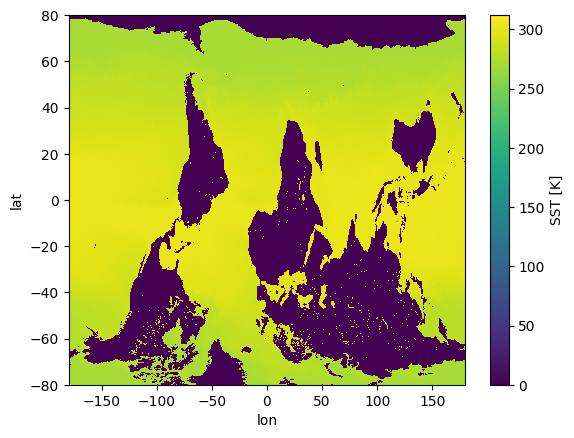

In [18]:
da = xds['SST']
da.plot()

In [22]:
xds = xds.assign_coords(lon=(((xds.lon + 180) % 360) - 180)).sortby("lon")

# Filter variables
variables = [var for var in xds.data_vars if "global" not in var]
for var in variables:
    data = xds[var].rio.write_crs("epsg:4326")  # Convert to rioxarray DataArray here
    
    data = data[::-1, :]
    # Reverse latitude if necessary
    #if data.lat.values[0] > data.lat.values[-1]:
        #data = data.isel(lat=slice(None, None, -1))
    
    # Set spatial dimensions
    data.rio.set_spatial_dims("lon", "lat", inplace=True)

    # Print the CRS
    print(data.rio.crs)
    
    # Generate unique filename for each variable
    cog_filename = f"{var}_cog.tif"
    
    # Write the COG
    data.rio.to_raster(
        cog_filename,
        driver="COG",
        compress="DEFLATE",
        overview_level=4,
        overview_resampling="average",
        nodata=-9999
    )
    
    # Validate the COG
    cog_valid = cogeo.cog_validate(cog_filename)
    print(f"COG Validation for {cog_filename}: {cog_valid}")

ERROR 1: PROJ: internal_proj_create_from_database: /Users/sidchaudhary/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /Users/sidchaudhary/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
COG Validation for SST_cog.tif: (True, [], [])


In [10]:
import matplotlib.pyplot as plt

# Path to your COG file
cog_filename = '/Users/sidchaudhary/Documents/GitHub/veda-cyclone/transformation_script/SST_cog.tif'

# Read the COG file
with rasterio.open(cog_filename) as src:
    # Read the data from the first band
    band1 = src.read(1)

    # Get the extent for the plot
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.imshow(band1, cmap='viridis', extent=extent)
plt.colorbar(label='Value')
plt.title('Visualization of COG')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


NameError: name 'rasterio' is not defined